In [1]:
import cmocean
import numpy as np
import xarray as xr
from os import path
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from thermal.plotting import make_colorbar

plt.rcParams['text.usetex'] = True

def amalgamate(base_fp, beta, surge_NT=40):

    # pseudo surge netcdf file
    surge_nc = f'crmpt12_dx_50_NT_{surge_NT}_dt_0.05_MB_-0.444_OFF_Tma_0.0_B_{beta:1.3e}_pseudo.zarr'
    surge_fp = path.join(base_fp.format('gridded'), surge_nc)
    # # second pseudo surge from recovered state
    # surge2_fp = surge_fp.split('.zarr')[0] + '_C2.zarr'

    # surge recovery netcdf file
    recovery_nc = surge_nc.split('.zarr')[0] + '_NT_3000_recovery.zarr'
    recovery_fp = path.join(base_fp.format('gridded'), recovery_nc)
    # # # second surge recovery netcdf file
    # recovery2_nc = surge_nc.split('.zarr')[0] + '_C2_NT_2000_recovery.zarr'
    # recovery2_fp = path.join(base_fp.format('thinned'), recovery2_nc)


    xarrays = []
    for i, fp in enumerate([surge_fp, recovery_fp]): #, surge2_fp, recovery2_fp]):

        src = xr.open_zarr(fp)
        
        src['relative_volume'] = src.relative_volume * src.initial_volume
      
        if i == 0:
            initial_volume = src.initial_volume.copy(deep=True)

        # drop the initial volume as it's meaningless 
        src = src.drop_vars('initial_volume')
        
        if i == 0:
            xarrays.append(src)
        else:
            # get the final timestep from previous the netcdf file
            t_f = xarrays[i-1].t.isel(t=-1)
            # extend the time coordinate
            src['t'] = src.t +  t_f

            xarrays.append(src)

    ds = xr.concat(xarrays, dim='t')
    
    ds['relative_volume'] = ds.relative_volume / initial_volume
    ds['initial_volume']  = initial_volume
    return ds

In [12]:
betas = np.logspace(-3, -4, 9)

In [13]:
base_fp = '/Volumes/thermal/Thesis/thermal-structure/'
expr_fp = 'expr/BB_TemperateControl/result/crmpt12/{}/'
src_fp  = path.join(base_fp, expr_fp)

In [14]:
___, norm, s_map, bounds = make_colorbar(-np.log(betas), cmap='magma')
#overwrite the colormap wiht a cmocean colormap
cmap = cmocean.cm.thermal

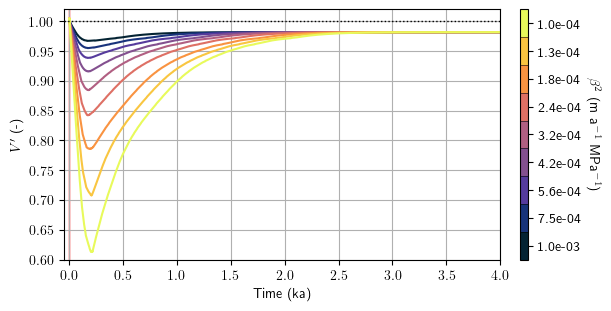

In [22]:
fig, ax = plt.subplots(1,1, sharex=True, 
                       figsize=(6,3),
                       constrained_layout=True)

ax.axvspan(0, 0.002, color='r', edgecolor=None,  alpha=1., zorder=-1)

for i, beta in enumerate(betas):
    
    color = cmap(norm(-np.log(beta)))
                
    test = amalgamate(src_fp, beta=beta)
    
    ax.plot(test.t/1e3, test.relative_volume, color=color)

ax.axhline(1.0, ls=':', c='k', lw=1.0)
    
ax.grid()
ax.set_ylabel("$V'$ (-)")
ax.set_xlabel('Time (ka)')

ax.set_xlim(-0.05,4)
ax.set_ylim(0.6, 1.02)

s_map = cm.ScalarMappable(norm=norm, cmap=cmap,)
s_map.set_array(-np.log(betas))

cbar = fig.colorbar(s_map, 
                    ax=ax, 
                    norm=norm, 
                    aspect=30,
                    pad=0.025,
                    spacing='proportional',
                    ticks=-np.log(betas), 
                    boundaries=bounds,
                    drawedges=True,
                    )
    
cbar.set_ticklabels(map(lambda x: f'{x:1.1e}', betas))
cbar.set_label(r"$\beta^2$ (m a$^{-1}$ MPa$^{-1}$)", rotation=270, labelpad=15)

fig.savefig('../figs/crmpt12/surge2steady_ISO_CNTRL.pdf')
fig.savefig('../figs/crmpt12/surge2steady_ISO_CNTRL.png',dpi=400)

In [11]:
betas

array([0.0001    , 0.00013335, 0.00017783, 0.00023714, 0.00031623,
       0.0004217 , 0.00056234, 0.00074989, 0.001     ])

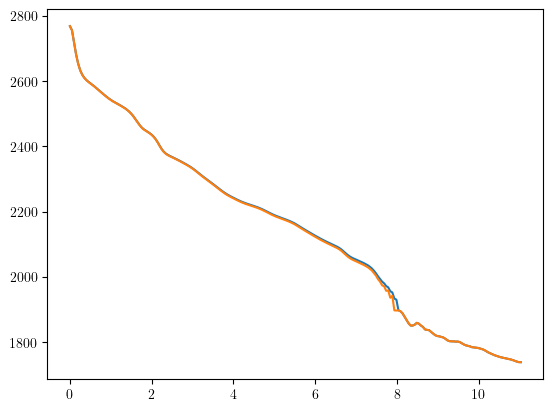

In [7]:
fig, ax = plt.subplots()

ax.plot(test.X[0,0,::-1]/1e3, 
        test.Z.isel(t=0, coord_2=-1), 
        label = 'Temperate')
ax.plot(test.X[0, 0,::-1]/1e3, 
        test.Z.isel(t=-1, coord_2=-1), 
        label = 'Temperate')


In [8]:
s_map